# P0: Progress to zero: A simple metric to measure COVID-19 progress by country/region

Juan M. Lavista Ferres MSC[a]1
, Ruth B Etzioni PhD[b]2
and William B. Weeks MD, MBA, PhD[c]1



## Abstract
 The current COVID-19 pandemic is having a devastating impact on the world. As of May 5th, 2020, more than half of the world is in lockdown,  3.6 million have been infected, and over 250K hav$ e died. This is the first pandemic in human history that has been tracked on a daily basis across the world. Currently, progress is being tracked by a series of metrics, including new cases, deaths, and epidemiologists have put a clear emphasis on tracking R(t). While we agree about the importance of R(t), we emphasize that R(t) does not capture the full story. The challenge with R(t), is that it is not observable and that the impact of  R(t) depends on the absolute number of active cases, so two geographies could show similar R(t) but very different situations. In this study, we propose an additional metric that we name “progress to zero” or P0. P0 corresponds to the percent decline from a previously recorded peak level. The metric will be 0% for any country that has not peaked on cases and will reach 100% when a country gets to 0 cases for at least seven days. The metric captures the importance of a country to learn how to reduce the current number of cases, can be tracked overtime and is also comparable across geographies and regions with very different population size.

In [70]:
import pandas as pd
import pyodbc 
from pandasql import sqldf
import seaborn as sns
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore') #only for presentation, remove for debug


For datasource we use ECDC covid-19 cases and deaths data

In [71]:
master_data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')

### Calculate latest progress to zero (PO) datapoint.

P0 at time i is defined one minus the ratio of A(i) to B(i), where A is the 7-day
moving average of new cases ending at day i and B is the 7-day moving average of
new cases corresponding to the historical peak. The measure could be defined using
a shorter interval for the moving average, or it could be defined using a weighted
moving average, but to illustrate the idea, we use a simple 7-day moving average.
Because the measure would not be stable with small numbers of cases, we recommend limiting measure application to geographies with at least 100 COVID-19
cases confirmed within a region.
Defining a 7-day moving average of cases and i as the current day, the calculations
are provided below:



\begin{equation*}
[1] ma(j) <- \frac{1}{7}\sum_{k=j-6}^{j} newcases[k]
\end{equation*}

\begin{equation*}
[2] P0=1-(\frac{ma(i)}{max(ma(7),...,ma(i))})
\end{equation*}

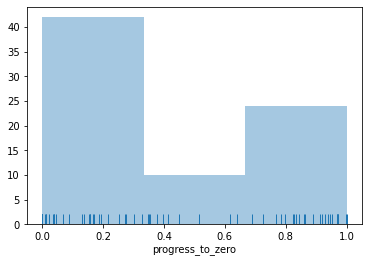

In [72]:
master_data['date_formatted']=pd.to_datetime(master_data.year.astype(str) + "-" + master_data.month.astype(str) + "-" + master_data.day.astype(str))
master_data['cases_moving_average']=master_data.groupby('countriesAndTerritories')['cases'].transform(lambda x: x.rolling(7, 1).mean())
master_data['deaths_moving_average']=master_data.groupby('countriesAndTerritories')['deaths'].transform(lambda x: x.rolling(7, 1).mean())

last_observation =pysqldf("SELECT countriesAndTerritories, max(cases_moving_average) as peak_cases,max(deaths_moving_average) as peak_deaths, max(date_formatted) as last_reported_date FROM master_data group by countriesAndTerritories order by date_formatted ;") 
progress_metric = pysqldf("SELECT last_observation.countriesAndTerritories, peak_cases, peak_deaths,  last_reported_date , cases_moving_average, deaths_moving_average from master_data, last_observation where last_observation.countriesAndTerritories=master_data.countriesAndTerritories and last_reported_date=master_data.date_formatted and cases_moving_average>=0 and peak_cases>100")
progress_metric['progress_to_zero']= 1- (progress_metric.cases_moving_average/progress_metric.peak_cases)
progress_metric['progress_to_zero_deaths']=1-(progress_metric.deaths_moving_average/progress_metric.peak_deaths)

sns.distplot(progress_metric.progress_to_zero, kde=False, rug=True);
progress_metric.to_clipboard()


Here we compute the metric overtime

In [73]:
moving_metric =pysqldf("SELECT countriesAndTerritories, deaths_moving_average,cases_moving_average,date_formatted FROM master_data order by countriesAndTerritories,date_formatted ;") 

current_country=""
current_max=0
moving_metric['moving_maximum']=0
moving_metric['moving_maximum_deaths']=0
for index, row in moving_metric.iterrows(): 
    if current_country != row['countriesAndTerritories']:#new country
        current_max=row['cases_moving_average']
        current_max_deaths=row['deaths_moving_average']
        current_country=row['countriesAndTerritories']
    if row['deaths_moving_average']>current_max_deaths:
        current_max_deaths=row['deaths_moving_average']
    if row['cases_moving_average']> current_max:
        current_max=row['cases_moving_average']
    moving_metric.loc[index, 'moving_maximum'] = current_max
    moving_metric.loc[index,'moving_maximum_deaths']=current_max_deaths
moving_metric['progress_to_zero']= 1- (moving_metric.cases_moving_average/moving_metric.moving_maximum)
moving_metric['progress_to_zero_deaths']=1-(moving_metric.deaths_moving_average/moving_metric.moving_maximum_deaths)
moving_metric[moving_metric.countriesAndTerritories=='Spain']
moving_metric=moving_metric[moving_metric.moving_maximum>100]
moving_metric.date_formatted=pd.to_datetime(df.date_formatted)

We compute the P0 metric for Australia, and we compare it with the moving average number of cases in Australia

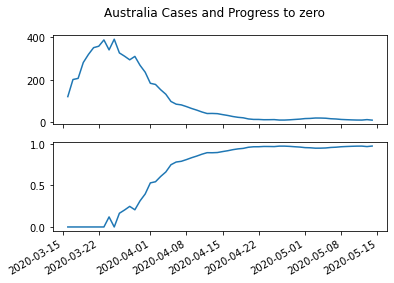

In [74]:
fig, axs = plt.subplots(2)

df=moving_metric
#df['DOB'] = pd.to_datetime(df.date_formatted)
#df['DOB1'] = df['DOB'].dt.strftime('%m/%d/%Y')


fig.suptitle('Australia Cases and Progress to zero')
x=moving_metric[moving_metric.countriesAndTerritories=='Australia'].date_formatted

fig.autofmt_xdate()
axs[0].fmt_xdata = mdates.DateFormatter('%Y-%m')

axs[0].plot(x,moving_metric[moving_metric.countriesAndTerritories=='Australia'].cases_moving_average)
axs[1].plot(x,moving_metric[moving_metric.countriesAndTerritories=='Australia'].progress_to_zero)


We also compute the metric for both cases and deaths for Spain

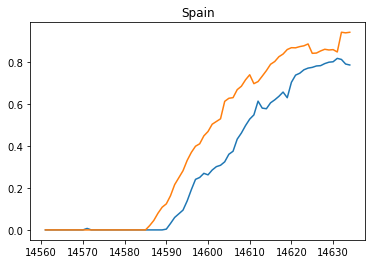

In [75]:
#gapminder[gapminder['year']==2002]
moving_metric[moving_metric.countriesAndTerritories=='Spain'].progress_to_zero_deaths.plot(title='Spain')
moving_metric[moving_metric.countriesAndTerritories=='Spain'].progress_to_zero.plot(title='Spain')


In [87]:
moving_metric[moving_metric.countriesAndTerritories=='Spain'].to_clipboard()

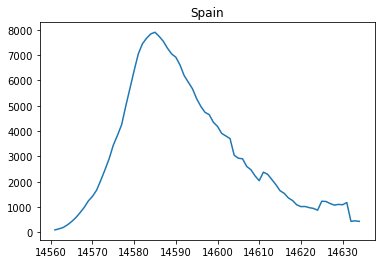

In [78]:
moving_metric[moving_metric.countriesAndTerritories=='Spain'].cases_moving_average.plot(title='Spain')

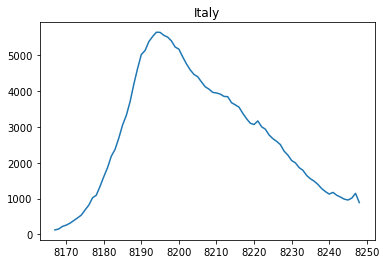

In [79]:
moving_metric[moving_metric.countriesAndTerritories=='Italy'].cases_moving_average.plot(title='Italy')

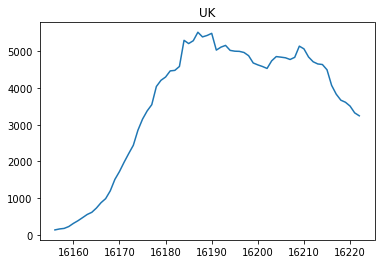

In [82]:
moving_metric[moving_metric.countriesAndTerritories=='United_Kingdom'].cases_moving_average.plot(title='UK')

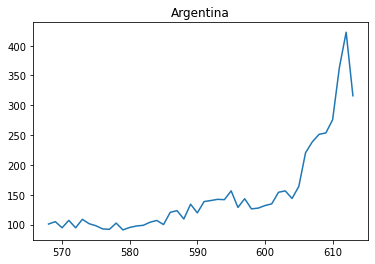

In [83]:
moving_metric[moving_metric.countriesAndTerritories=='Argentina'].cases_moving_average.plot(title='Argentina')

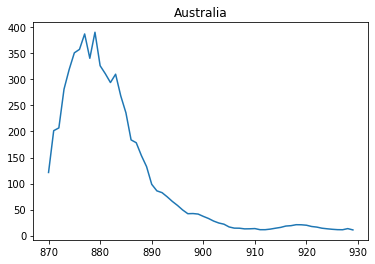

In [85]:
moving_metric[moving_metric.countriesAndTerritories=='Australia'].cases_moving_average.plot(title='Australia')

In [129]:
#Switzerland
#Taiwan
#Estonia
#Israel
#New_Zealand
#South_Korea
#Thailand
#China

#top_countries=progress_metric[progress_metric.progress_to_zero<=0]
#top_countries
progress_metric.to_clipboard()
#master_data[master_data.countriesAndTerritories=='Djibouti'].cases_moving_average.plot(title='Iceland')

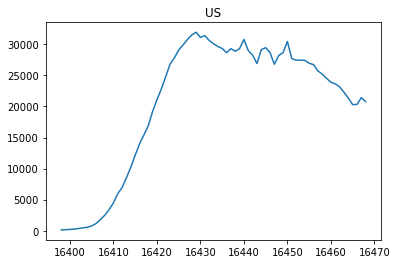

In [87]:
moving_metric[moving_metric.countriesAndTerritories=='United_States_of_America'].cases_moving_average.plot(title='US')